In [3]:
import importlib
import sys  

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers.timeseries import TimeGAN
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#select the GAN model
model = WGAN_GP

#Setting the parameters of the GAN model
noise_dim = 32
dim = 128
batch_size = 32

log_step = 20
epochs = 1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
#models_dir = './cache'

#Setting the model parameters and the training step parameters of the GAN model
gan_args = ModelParameters(batch_size=batch_size, lr=learning_rate, betas=(beta_1, beta_2),
                           noise_dim=noise_dim,layers_dim=dim)

#train_args = TrainParameters(epochs=epochs, sample_interval=log_step)

import os

import pandas as pd 


gen_data=pd.read_csv("breast_most_variant_genes_train.csv",header=0,index_col=0)
gen_data=gen_data.T

gen_data = np.log(1 + gen_data)
x_mean = np.mean(gen_data, axis=0)
x_std = np.std(gen_data, axis=0)
gen_data = (gen_data - x_std)/x_mean

train_data=gen_data


num_cols = list(train_data.columns)
cat_cols = None

train_args = TrainParameters(epochs=epochs, sample_interval=log_step)

In [12]:
model_steps = [ 500,700]
base_dir = 'cache/'
z = np.random.normal(size=(400, 32))


# 1 create generated milestone 
# plot the relavant metrics for those milestones

# Generate 4 mile stone 

for model_step in model_steps: 
    generator_model=model(gan_args, n_critic = 10)

    #generator_model.train(data = train_data, train_arguments = train_args, num_cols = num_cols, cat_cols = cat_cols)
    generator_model.train(data = train_data, train_arguments = train_args, num_cols = num_cols, cat_cols = cat_cols)

    generator_model_2=generator_model.generator
    generator_model_2.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    g_z = generator_model_2.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=train_data.columns)
    gen_samples.to_csv(f'gen/Generated_sample_{model_step}.csv')


100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

Epoch: 0 | disc_loss: -1.1075416803359985 | gen_loss: -0.8760553002357483



100%|██████████| 1/1 [00:06<00:00,  6.99s/it]

Epoch: 0 | disc_loss: -1.2615927457809448 | gen_loss: 0.5107101798057556


# Scatter plots replication

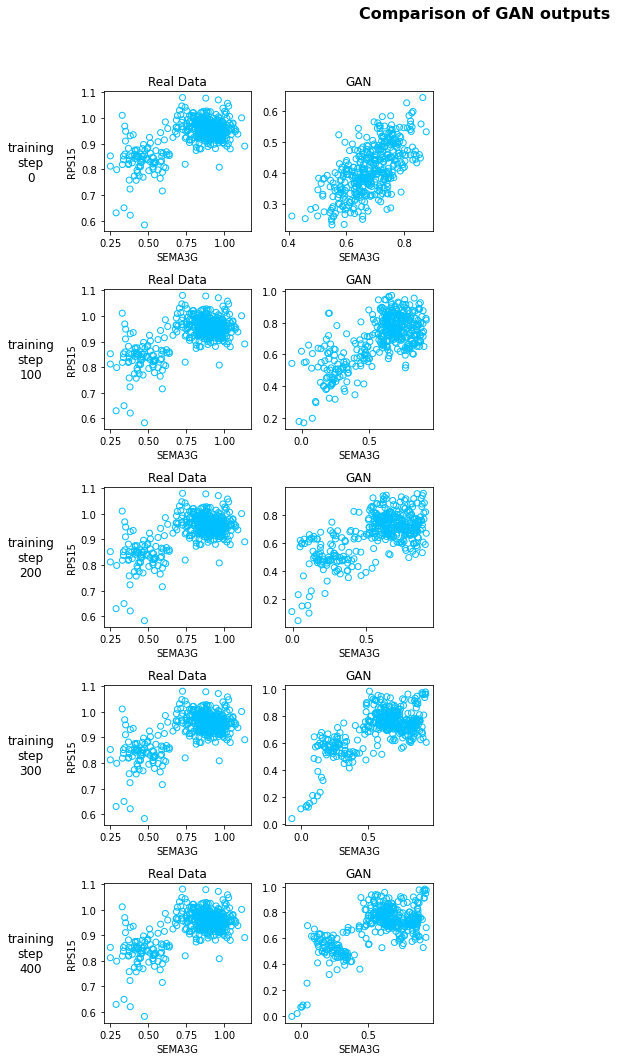

In [26]:
model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
#class_labels = ['Class 1','Class 2']
col1, col2 = 'SEMA3G', 'RPS15'
base_dir = 'cache_old/'

#Actual fraud data visualization
model_steps = [ 0,100,200,300,400]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    # for group, color, marker, label in zip(real_samples.groupby('Class'), colors, markers, class_labels ):
    plt.scatter(
        train_data[[col1]], train_data[[col2]], 
        marker='o', edgecolors=['deepskyblue'], facecolors='none' )
    
    plt.title('Real Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    


    # if model_step_ix == 0: 
        # legend = plt.legend()
        # legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):

        model_name, with_class, generator_model =  'GAN', False, model(gan_args, n_critic = 10)

        #generator_model.train(data = train_data, train_arguments = train_args, num_cols = num_cols, cat_cols = cat_cols)

        #generator_model_2=generator_model.generator
        #generator_model_2.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        #ax.set_xlim([-2,2]), ax.set_ylim([-2,2])

        #g_z = generator_model_2.predict(z)
        #gen_samples = pd.DataFrame(g_z, columns=real_samples.columns)
        #gen_samples.to_csv('Generated_sample.csv')
        gen_samples=pd.read_csv(f'gen/Generated_sample_{model_step}.csv')
        plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                        marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(col1)
        #ax.set_xlim(xlims), ax.set_ylim(ylims)
        #plt.ylim([-1, 0])


plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

# TSNE

In [28]:
# TSNEs

from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  
import umap.umap_ as umap

def tsne_2d(data, **kwargs):
    """
    Transform data to 2d tSNE representation
    :param data: expression data. Shape=(dim1, dim2)
    :param kwargs: tSNE kwargs
    :return:
    """
    print('... performing tSNE')
    tsne = TSNE(n_components=2, **kwargs)
    return tsne.fit_transform(data)


def plot_tsne_2d(data, labels, **kwargs):
    """
    Plots tSNE for the provided data, coloring the labels
    :param data: expression data. Shape=(dim1, dim2)
    :param labels: color labels. Shape=(dim1,)
    :param kwargs: tSNE kwargs
    :return: matplotlib axes
    """
    dim1, dim2 = data.shape

    # Prepare label dict and color map
    label_set = set(labels)
    label_dict = {k: v for k, v in enumerate(label_set)}

    # Perform tSNE
    if dim2 == 2:
        # print('plot_tsne_2d: Not performing tSNE. Shape of second dimension is 2')
        data_2d = data
    elif dim2 > 2:
        data_2d = tsne_2d(data, **kwargs)
    else:
        raise ValueError('Shape of second dimension is <2: {}'.format(dim2))

    # Plot scatterplot
    for k, v in label_dict.items():
        plt.scatter(data_2d[labels == v, 0], data_2d[labels == v, 1],
                    label=v)
    plt.legend()
    return plt.gca()

AttributeError: 'list' object has no attribute '_position'

<Figure size 1008x1728 with 0 Axes>

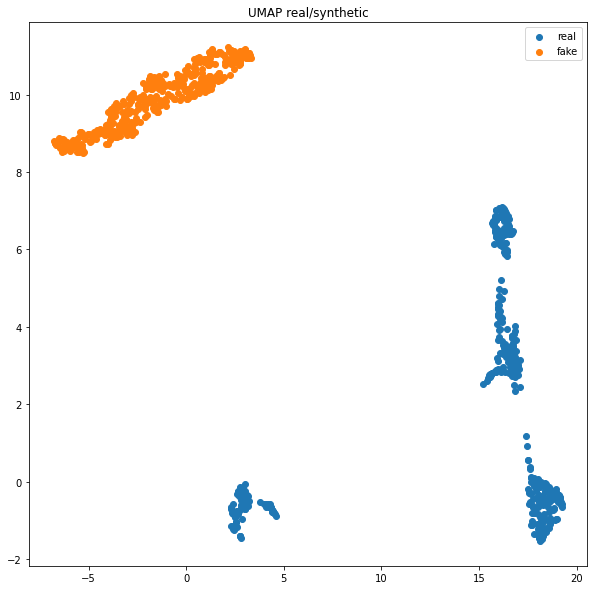

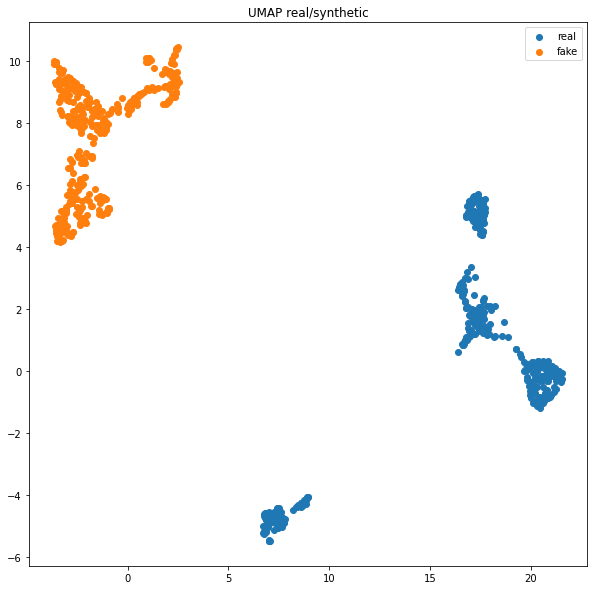

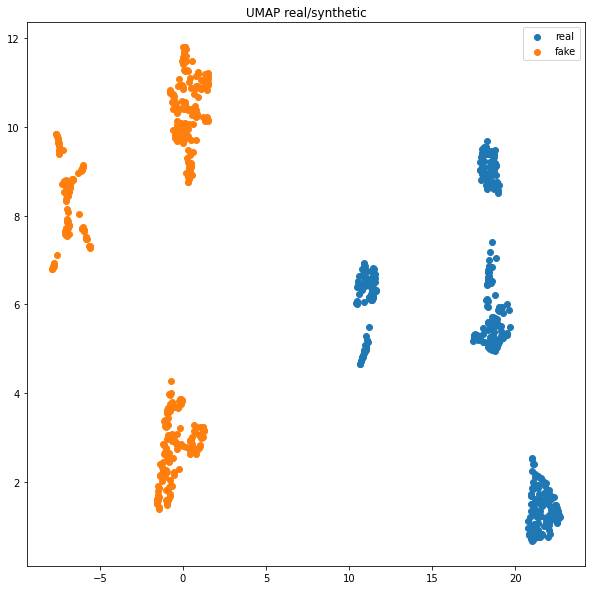

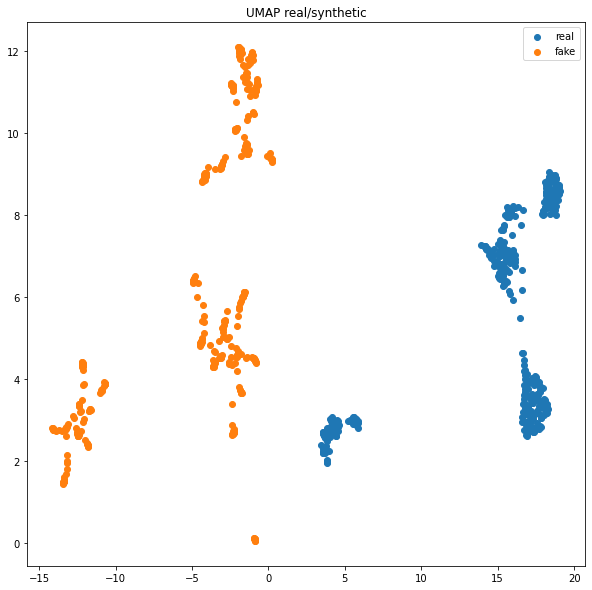

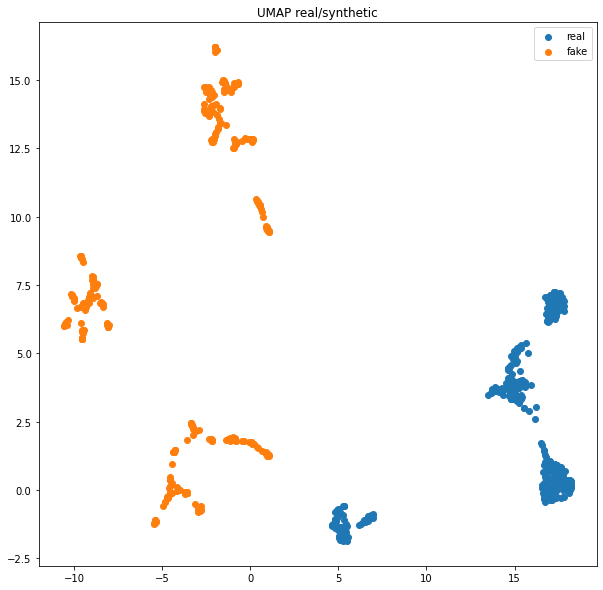

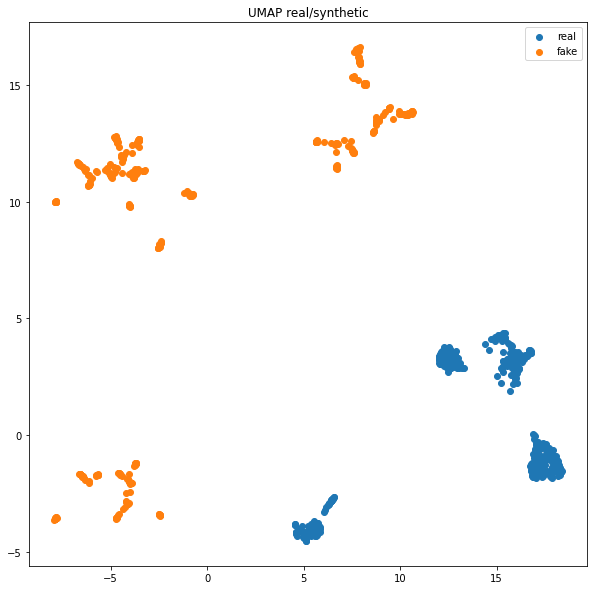

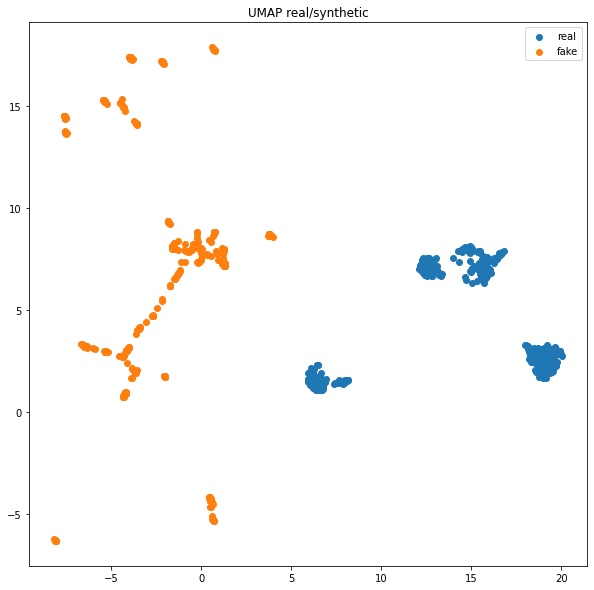

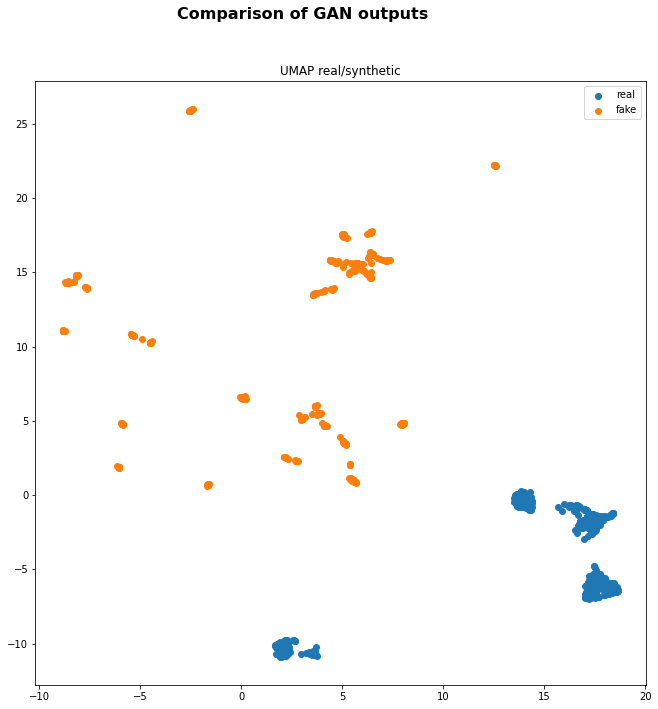

In [40]:

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
#class_labels = ['Class 1','Class 2']
col1, col2 = 'SEMA3G', 'RPS15'
base_dir = 'cache_old/'

#Actual fraud data visualization
model_steps = [ 0,100,200,500,600,700,800,900]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        


        #ax.set_xlim([-2,2]), ax.set_ylim([-2,2])

        #g_z = generator_model_2.predict(z)
        #gen_samples = pd.DataFrame(g_z, columns=real_samples.columns)
        #gen_samples.to_csv('Generated_sample.csv')
        gen_samples=pd.read_csv(f'gen/Generated_sample_{model_step}.csv',index_col=0)
        df_synth=gen_samples
        df_train=train_data
        x_combined = np.concatenate((df_train, df_synth))
        categories = ['real'] * df_train.shape[0] + ['fake'] * df_synth.shape[0]

        emb_2d = umap.UMAP().fit_transform(x_combined)

        plt.figure(figsize=(10, 10))
        plot_tsne_2d(emb_2d, labels=np.array(categories), s=4)
        plt.title('UMAP real/synthetic')
        #ax.set_xlim(xlims), ax.set_ylim(ylims)
        #plt.ylim([-1, 0])


plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')




# Distributions

'GPX3'